## Imports

In [ ]:
from scipy.integrate import solve_ivp
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate Synthetic Data

In [ ]:
# ODE
def damped_oscillator(t, y):
    # Parameters
    gamma_val = 0.1
    omega_val = 1.0

    x1, x2 = y
    dx = x2
    dx2 = (-2 * gamma_val * x2) - ((omega_val**2) * x1)
    return [dx, dx2]

# IC, x(0) = 1, x'(0) = 0
x0 = [1.0, 0.0]

# Time range
t_span = (0, 10)

# -----------------------------------------------

# Get data points
t_eval = np.linspace(0, 10, 100)

# Solve the system of ODEs
sol = solve_ivp(damped_oscillator, t_span, x0, t_eval=t_eval)

# Get input and output values
t_data = sol.t
x_data = sol.y[0]

t_eval = np.linspace(0, 10, 30)

# -----------------------------------------------

# Get test data
t_eval = np.linspace(0, 10, 50)

# Solve the system of ODEs
sol = solve_ivp(damped_oscillator, t_span, x0, t_eval=t_eval)

# Get input and output values
t_test = sol.t
x_test = sol.y[0]

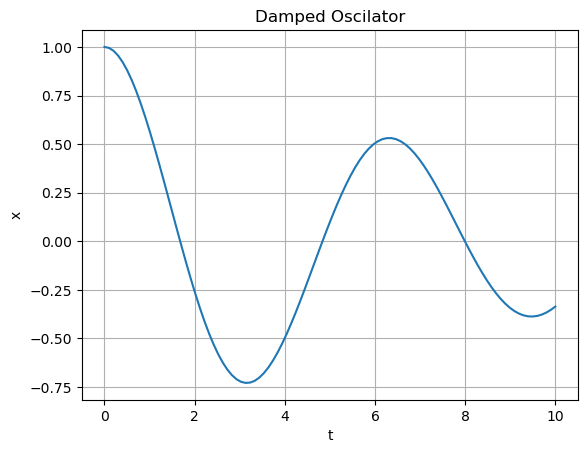

In [ ]:
# Plotting the Omega over epochs
plt.plot(t_data, x_data)
plt.title('Damped Oscilator')
plt.xlabel('t')
plt.ylabel('x')
plt.grid(True)
plt.show()

# PINN Model

### Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, n_hidden_layers=1):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Tanh())
        self.hidden_layers = self._make_hidden_layers(n_hidden_layers, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def _make_hidden_layers(self, n_hidden_layers, hidden_size):
        layers = []
        for _ in range(n_hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

### Loss Function

In [ ]:
gamma, omega = 0.1, 1
def pinn_loss(x_ic, t_ic, x_data_pred, x_data_true, x_ode, t_ode):
    # Calculate data loss (IC)
    loss_data_1 = (torch.squeeze(x_ic) - 1)**2
    dx_ic = torch.autograd.grad(x_ic, t_ic, torch.ones_like(x_ic), create_graph=True)[0]
    loss_data_2 = (torch.squeeze(dx_ic) - 0)**2

    # Do MSE
    loss_mse = torch.mean((x_data_pred-x_data_true)**2)

    # Calculate Physics loss
    dx = torch.autograd.grad(x_ode, t_ode, torch.ones_like(x_ode), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, t_ode, torch.ones_like(dx), create_graph=True)[0]
    ode = dx2 + (2*gamma*dx) + (omega**2)*x_ode
    loss_ode = torch.mean(ode**2)

    # Add together and return
    return loss_data_1 + loss_data_2 + loss_ode + loss_mse

# Training the Model and Parameter Inference

In [ ]:
# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1,1)
x_data_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1,1)

t_ode_tensor = torch.linspace(0,10,100).view(-1,1).requires_grad_(True)

t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1,1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1,1)

cpu


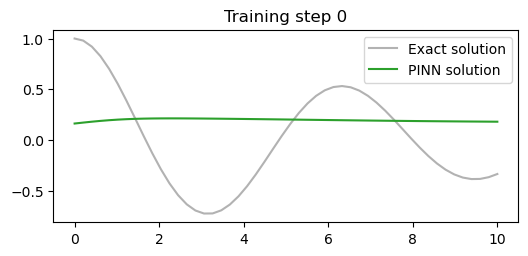

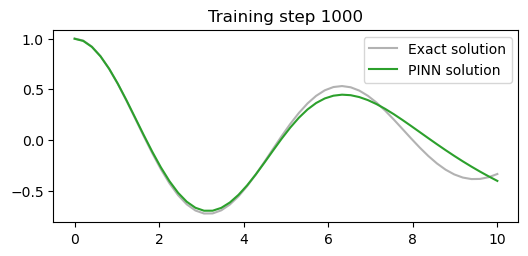

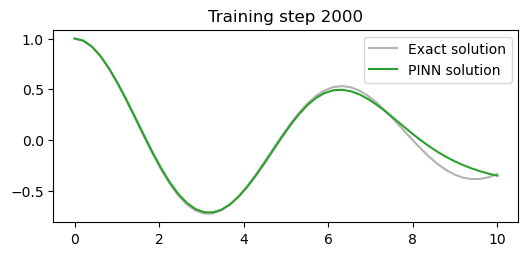

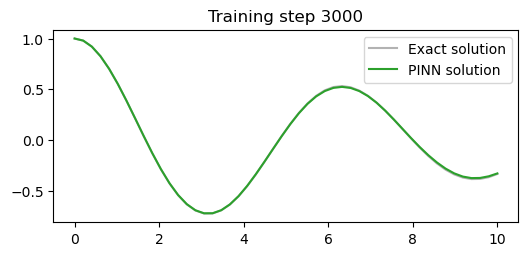

In [ ]:
# Trainable parameters
gamma = nn.Parameter(torch.tensor(0.5, requires_grad=True))
omega = nn.Parameter(torch.tensor(0.5, requires_grad=True))
gamma_lst = []
omega_lst = []

# Initialize parameters for the model
n_epochs =3001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = NeuralNetwork(1, 32, 1, 3).to(device)
optimizer = optim.Adam(list(model.parameters()) + [gamma, omega], lr=0.001)

# Set data to devive
t_data_tensor = t_data_tensor.to(device)
x_data_tensor = x_data_tensor.to(device)
t_ode_tensor = t_ode_tensor.to(device)

t_test_tensor = t_test_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)

# Boundary t value
t_ic = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)

for i in range(n_epochs):
    optimizer.zero_grad()

    # Predict for data loss
    x_ic = model(t_ic)
    x_data_pred = model(t_data_tensor)

    # Predict for physics
    x_ode_pred = model(t_ode_tensor)

    # Calculate loss
    loss = pinn_loss(x_ic, t_ic, x_data_pred, x_data_tensor, x_ode_pred, t_ode_tensor)
    loss.backward()
    optimizer.step()

    # Record training parameters
    gamma_lst.append(gamma.item())
    omega_lst.append(omega.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        x_test_pred = (model(t_test_tensor)).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_test_tensor.detach().numpy(), x_test_tensor.detach().numpy(), label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test_tensor.detach().numpy(), x_test_pred.numpy(), label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

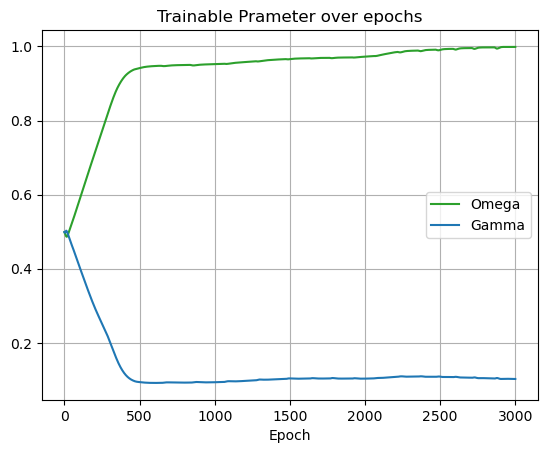

In [ ]:
# Plotting the Omega and Gamma over epochs
plt.title('Trainable Prameter over epochs')
plt.plot(range(n_epochs), omega_lst, label="Omega", color="tab:green")
plt.plot(range(n_epochs), gamma_lst, label ="Gamma", color="tab:blue")
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()